## Exploratory Data Analysis (Keystroke Dataset)

In [4]:
from functools import partial
from time import monotonic

import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from sklearn.cluster import SpectralClustering, KMeans, AgglomerativeClustering
from sklearn.metrics import r2_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from tqdm.auto import tqdm

In [5]:
plt.style.use('./plt_style.txt')

In [6]:
keystrokes = pd.read_csv('IDE_Data/IDE data/IDE_data.csv', index_col=0)
grades = pd.read_csv('IDE_Data/IDE data/points.csv', index_col=0)

In [7]:
keystrokes.time_to_deadline.dtype

dtype('int64')

In [8]:
%matplotlib widget

---

# Analysis

## Keystroke Summary

In [32]:
grades

,part1,part2,part3,part4,part5,part6,part7,exam1,exam2,exam3,final
student,,,,,,,,,,,
0,0.9,1.0,0.7,0.2,0.7,0.0,0.0,1.0,0.0,0.0,0.371
1,1.0,0.9,0.8,1.0,0.9,0.9,0.9,1.0,0.8,0.5,0.822
2,1.0,1.0,1.0,0.9,1.0,1.0,0.9,1.0,0.9,1.0,0.969
3,1.0,1.0,1.0,1.0,1.0,0.5,0.0,1.0,1.0,0.0,0.680
4,0.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063
...,...,...,...,...,...,...,...,...,...,...,...
444,1.0,0.9,0.4,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.254
445,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.8,1.0,0.970
446,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.000


In [9]:
keystrokes

,event_type,exercise,time_to_deadline
student,,,
0,focus_gained,1,737739
0,focus_lost,1,737712
0,focus_gained,1,737693
0,focus_lost,1,737688
0,focus_gained,1,737617
...,...,...,...
448,run,30,3556537
448,submit,30,3556523
448,focus_gained,30,1330841


In [10]:
f"Average number of events per student {keystrokes.groupby(keystrokes.index).time_to_deadline.count().mean()}"

'Average number of events per student 9418.501113585746'

In [11]:
f"Number of students: {len(keystrokes.index.unique())}"

'Number of students: 449'

In [12]:
f"Number of students with non-zero final exam grades: {(grades.exam3 != 0).sum()}"

'Number of students with non-zero final exam grades: 189'

In [13]:
f"Number of events: {len(keystrokes.index)}"

'Number of events: 4228907'

In [14]:
keystrokes.event_type.value_counts()

text_insert     2795877
text_remove      849338
focus_gained     238840
focus_lost       230517
run               73536
text_paste        26259
submit            14540
Name: event_type, dtype: int64

## Final Grade Calculation

In [15]:
grades["final"] = grades.part1 * 0.07 + grades.part2 * 0.08 + grades.part3 * 0.08 + grades.part4 * 0.08 + grades.part5 * 0.08 + grades.part6 * 0.08 + grades.part7 * 0.08 + grades.exam1 * 0.1 + grades.exam2 * 0.15 + grades.exam3 * 0.2

## Grade Distributions

In [73]:
@interact(assessment=grades.columns)
def plot_grades(assessment):
    plt.figure(figsize=(10,8))
    plt.hist(grades[assessment])
    plt.grid(alpha=0.4)
    plt.xlabel('Grade')
    plt.ylabel('Count')
    plt.title(f'Grade distribution on {assessment}')
    plt.show()

interactive(children=(Dropdown(description='assessment', options=('part1', 'part2', 'part3', 'part4', 'part5',…

### Questions

1. The grade distribution is very bimodial, with a surprisingly high proportion of failures/dns
   * What was the overall marking scheme? i.e. how was the final grade calculated?
   * Was data collected on whether or not a student sat the exams/did the coursework parts?
   * Does the university allow some form of 'free drop' and are those students included in this data?

## Summary Features

In [16]:
groups = keystrokes.groupby([keystrokes.index, keystrokes.exercise])

In [17]:
time_to_first_event = groups.time_to_deadline.max().unstack(level=-1)

In [18]:
time_to_last_event = groups.time_to_deadline.min().unstack(level=-1)

In [19]:
ks_submits = keystrokes.where(keystrokes.event_type == 'submit')
first_submit = ks_submits.groupby([ks_submits.index, ks_submits.exercise]).time_to_deadline.first().unstack(level=-1)

In [20]:
differences = -groups.time_to_deadline.diff()
all_latencies = differences.groupby('student')
filtered_latencies = all_latencies.apply(lambda x: x.where(x < differences.quantile(0.995).item()))

In [21]:
mean_latency = filtered_latencies.groupby('student').mean()
fine_time_on_task = filtered_latencies.groupby('student').sum()

In [22]:
keystroke_counts = keystrokes.groupby(keystrokes.index).event_type.apply(pd.value_counts).unstack(level=1).fillna(0);

In [23]:
summary_features = keystroke_counts.assign(
    time_to_last = time_to_last_event.mean(axis=1),
    time_to_first=time_to_first_event.mean(axis=1),
    duration=(time_to_first_event-time_to_last_event).mean(axis=1),
    coarse_time_on_task=(time_to_first_event-first_submit).mean(axis=1),
    fine_time_on_task=fine_time_on_task,
    mean_latency=mean_latency
)
summary_features['coarse_time_on_task']=summary_features['coarse_time_on_task'].fillna(summary_features['coarse_time_on_task'].max()+100)
summary_features

,focus_gained,focus_lost,run,submit,text_insert,text_paste,text_remove,time_to_last,time_to_first,duration,coarse_time_on_task,fine_time_on_task,mean_latency
student,,,,,,,,,,,,,
0,335.0,327.0,94.0,30.0,4744.0,59.0,1068.0,6.321593e+05,7.063017e+05,74142.466667,427.965517,16403.0,2.485680
1,327.0,325.0,205.0,37.0,7050.0,45.0,1878.0,1.619366e+06,1.705339e+06,85972.709677,29270.806452,29665.0,3.028586
2,711.0,672.0,161.0,31.0,4660.0,80.0,894.0,8.689788e+05,1.510658e+06,641678.900000,8861.000000,25476.0,3.614130
3,100.0,89.0,0.0,30.0,284.0,28.0,156.0,2.789468e+06,2.789502e+06,33.612903,7.400000,1042.0,1.588415
4,311.0,310.0,82.0,39.0,4552.0,20.0,845.0,3.481572e+06,3.482497e+06,925.142857,833.333333,8897.0,1.451860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,168.0,166.0,74.0,31.0,5559.0,1.0,1346.0,3.317407e+06,3.333872e+06,16465.193548,3432.433333,13552.0,1.861538
445,507.0,448.0,213.0,30.0,16526.0,2.0,3101.0,3.403741e+06,3.543950e+06,140208.935484,473.533333,42809.0,2.067868
446,369.0,365.0,131.0,32.0,4122.0,114.0,1861.0,3.160902e+06,3.163844e+06,2942.233333,478.233333,16447.0,2.366815


## Dimensionality Reduction

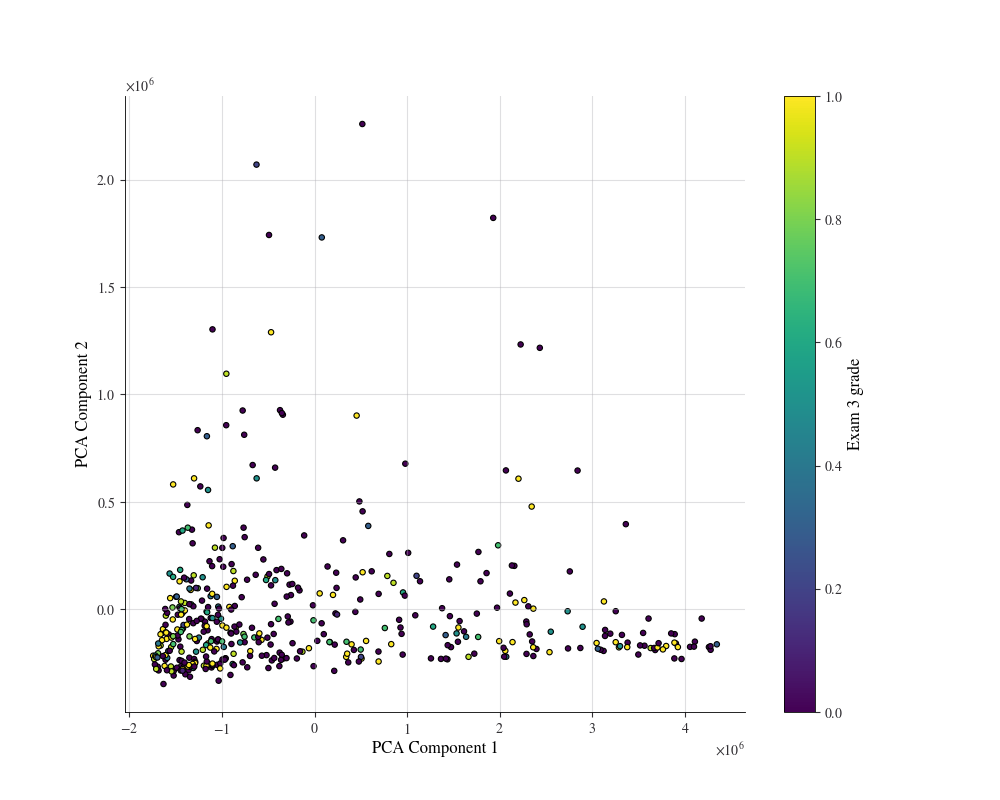

In [68]:
pca = PCA(n_components=2, random_state=42)
reduced_pca = pca.fit_transform(summary_features)
plt.figure(figsize=(10,8))
plt.grid(alpha=0.4)
plt.scatter(reduced_pca[:,0], reduced_pca[:,1], c=grades.exam3, s=15)
plt.colorbar(label="Exam 3 grade")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2");

## HMM

Prior work has proposed designed state models based on various events sourced from programming activity.

As an alternative to these designed models we experiment with a HMM trained on each student. The parameters of this HMM (start state, transition probabilities, emission probabilities) are used as the input to a regressor (a support vector regressor or random forest regressor).

In [19]:
train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, stratify=grades.exam3)

In [20]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

LabelEncoder()

In [22]:
X = []
for studentid, student_keystrokes in tqdm(keystrokes.groupby(keystrokes.index)):
    model = hmm.GaussianHMM(n_components=5)
    model.fit(
        encoder.transform(student_keystrokes.event_type.to_numpy()).reshape(-1, 1),
        student_keystrokes.groupby("exercise").apply(lambda x: x.shape[0]).to_numpy()
    )
    params = np.concatenate((model.startprob_, model.transmat_.reshape(-1), model.means_.reshape(-1), model.covars_.reshape(-1)))
    X.append(params)
X = np.array(X)

### SVM

In [22]:
clf = SVR()
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

NameError: name 'X' is not defined

### Random Forest

In [23]:
clf = RandomForestRegressor(n_jobs=-1)
clf.fit(X[train_ids], grades.exam3[train_ids])
predicted = clf.predict(X[test_ids])
r2_score(grades.exam3[test_ids], predicted)

NameError: name 'X' is not defined

In [24]:
@interact(feat=widgets.Dropdown(options=list(range(X.shape[1])), value=np.argmax(clf.feature_importances_)))
def plot_residuals(feat):
    plt.scatter(X[test_ids, feat], predicted-grades.exam3[test_ids])
    plt.axhline(0, ls='--', color='grey')

NameError: name 'X' is not defined

Time based classifiers and clustering algorithms.

### Old

In [12]:
keystrokes_np = list(ks.to_numpy() for student, ks in keystrokes.groupby(keystrokes.index))
for i in tqdm(range(len(keystrokes_np)), total=len(keystrokes_np)):
    keystrokes_np[i][:,0] = encoder.transform(keystrokes_np[i][:,0].reshape(-1,1))
    keystrokes_np[i] = np.delete(keystrokes_np[i], 1, axis=1)
    keystrokes_np[i] = np.c_[keystrokes_np[i][:,1], keystrokes_np[i][:,0]]
    keystrokes_np[i] = np.pad(keystrokes_np[i], [(0, 55750-keystrokes_np[i].shape[0]), (0,0)])
#keystrokes_np

In [14]:
np.array(keystrokes_np).shape

(449, 55750, 2)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(np.array(keystrokes_np), grades.final)
classifier = ComposableTimeSeriesForestRegressor(n_jobs=-1)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy_score(y_test, y_pred)

ValueError: X must be univariate with X.shape[1] == 1, but found: X.shape[1] == 55750.

In [26]:
from sktime.datasets import load_arrow_head

In [33]:
load_arrow_head()[0].iloc[0]

dim_0    0     -1.963009
1     -1.957825
2     -1.95614...
Name: 0, dtype: object

In [29]:
load_arrow_head()[1]

array(['0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0',
       '1', '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '1',
       '2', '0', '1', '2', '0', '1', '2', '0', '1', '2', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2',
       '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2', '2

### New

In [21]:
index = pd.MultiIndex.from_arrays([keystrokes.index, keystrokes.time_to_deadline.max()-keystrokes.time_to_deadline])

In [22]:
keystrokes_sktime = pd.DataFrame(encoder.transform(keystrokes.event_type), index)

## Summary Classification

In [24]:
train_ids, test_ids = train_test_split(keystrokes.index.unique(), test_size=0.5, stratify=grades.exam3)

In [25]:
encoder = LabelEncoder()
encoder.fit(list(keystrokes.event_type.value_counts().index))

LabelEncoder()

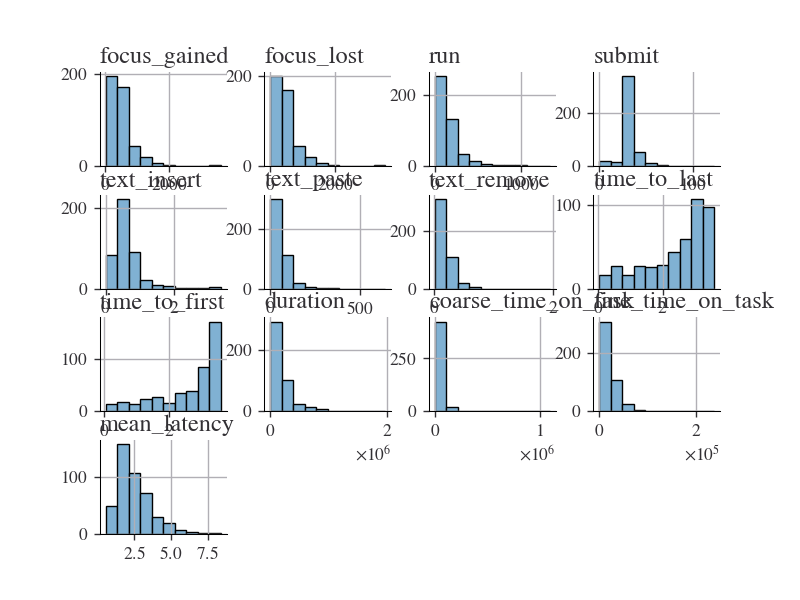

In [26]:
summary_features.hist();

In [27]:
summary_features_norm = Normalizer().fit_transform(summary_features)

In [34]:
import pickle
with open('good.pickle', 'wb') as f:
    pickle.dump(summary_features, f)
with open('good_grades.pickle', 'wb') as f:
    pickle.dump(grades, f)

In [35]:
clf = RandomForestRegressor(random_state=42)
clf.fit(summary_features.iloc[train_ids], grades.final[train_ids])
predicted = clf.predict(summary_features.iloc[test_ids])
r2_score(grades.final[test_ids], predicted)

0.3978756393202656

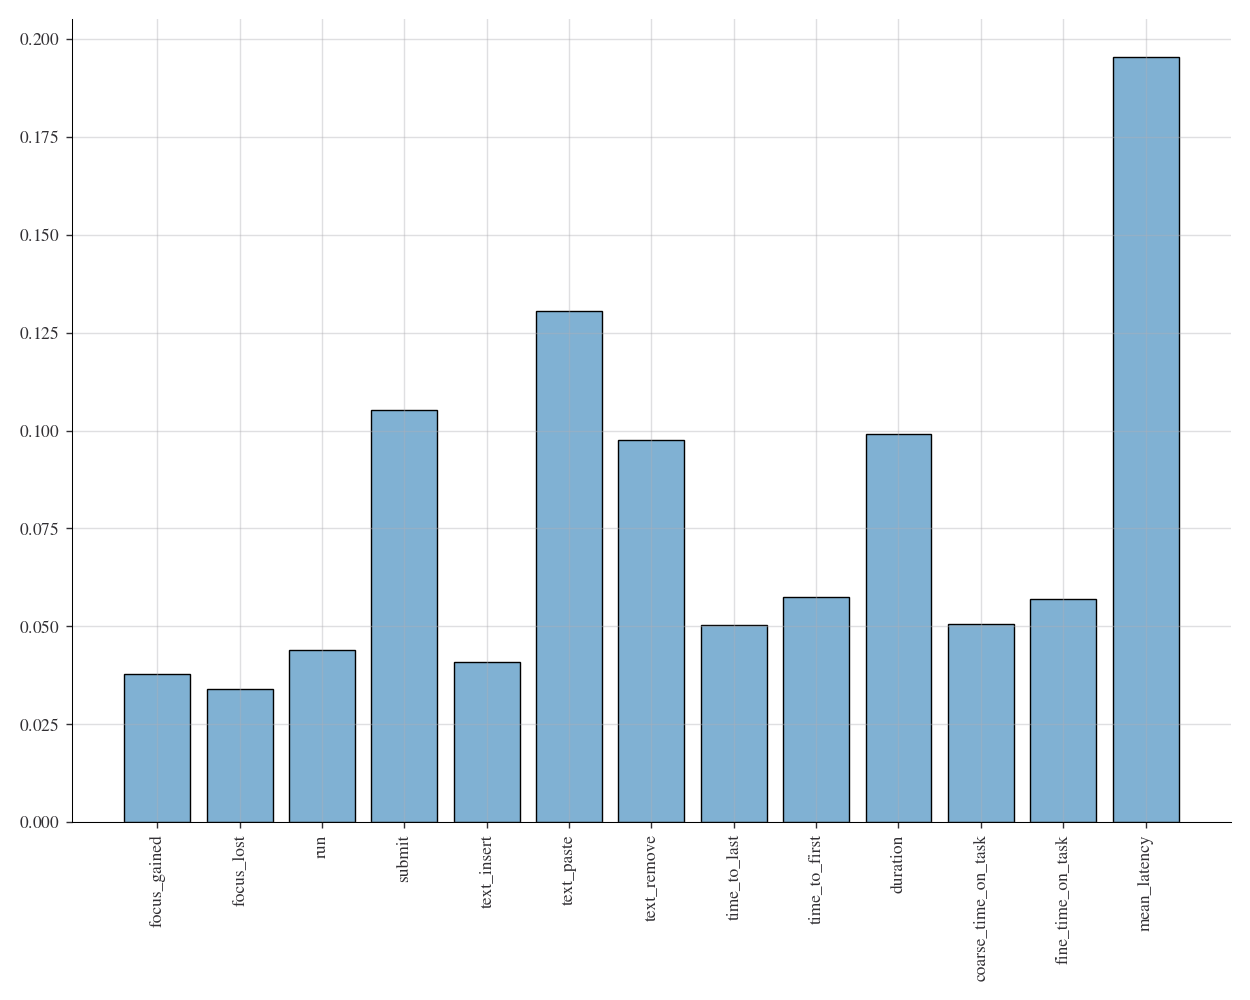

In [29]:
plt.figure(figsize=(10,8))
plt.bar(summary_features.columns, clf.feature_importances_)
plt.xticks(rotation='vertical')
plt.grid(alpha=0.4)
plt.tight_layout();

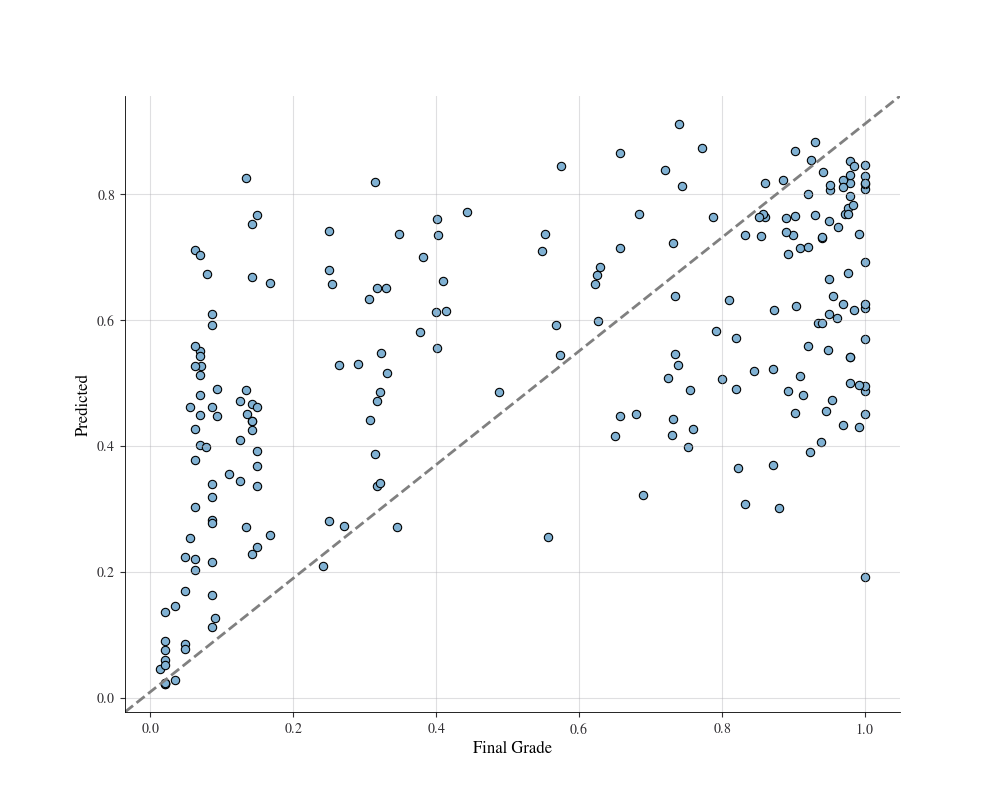

In [25]:
plt.figure(figsize=(10,8))
plt.scatter(grades.final[test_ids], predicted)
plt.xlabel("Final Grade")
plt.ylabel("Predicted")
plt.grid(alpha=0.4)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='grey', ls='--');